In [1]:
import networkx as nx # the main libary we will use
from networkx.algorithms import bipartite
from networkx.algorithms import community, centrality
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions.plots import plot_knn, plot_snn, plot_histogram, plot_distance_dist, plot_degree_distribution, plot_gamma
from functions.plots import plot_giant_component, plot_weight_dist, plot_company_market_distribution, plot_clustering_coefficient
from functions.statistics import print_degree_correlation_coefficient
from functions.graphs import make_companies_graph, make_investors_graph
%matplotlib inline 
from collections import defaultdict
from networkx.algorithms import community
from networkx.algorithms import bipartite
from networkx.algorithms import centrality as ce
from networkx.algorithms import community as c
from community import community_louvain
from networkx.algorithms.community import greedy_modularity_communities

In [2]:
file= 'data/Investments.xlsx'
df = pd.read_excel(file)

### Preprocess

In [3]:
df = df[['company_name','company_market','investor_name','funded_year','raised_amount_usd']]
df.rename(columns = {'company_name' : 'Company_Name', 'company_market' : 'Company_Market', 'investor_name':'Investor_Name', 'funded_year':'Funded_Year', 'raised_amount_usd':'Raised_Amount_USD'}, inplace = True)
df = df.dropna()
df = df[df.Raised_Amount_USD != 0]
df = df[df.Funded_Year>=1990]
original_df = df

In [4]:
df.head()

,Company_Name,Company_Market,Investor_Name,Funded_Year,Raised_Amount_USD
31,Knowledge Adventure,Games,William Lohse,1990,60000.0
43,Market Wire,Advertising,Hummer Winblad Venture Partners,1990,17550000.0
44,Market Wire,Advertising,Mindful Investors,1990,17550000.0
45,Market Wire,Advertising,Montreux Equity Partners,1990,17550000.0
46,Market Wire,Advertising,Osprey Ventures,1990,17550000.0


### Data exploration

In [5]:
print(f"Number of unique investors: {df['Investor_Name'].nunique()}")
print(f"Number of unique companies: {df['Company_Name'].nunique()}")
print(f"Number of unique company markets: {df['Company_Market'].nunique()}")
print(f"Number of unique years: {df['Funded_Year'].nunique()}")
print(f"Number of investments: {df.shape[0]}")

Number of unique investors: 20156
Number of unique companies: 24908
Number of unique company markets: 695
Number of unique years: 23
Number of investments: 99090


#### Split the data by years

In [6]:
years_range = [(1990, 1994), (1995, 1999), (2000, 2004), (2005,2009), (2010, 2014)]
years_dict = {i:year_range for i,year_range in enumerate(years_range)}
df_list =[df[(df['Funded_Year'] <= year_range[1]) & (df['Funded_Year'] >= year_range[0])] for year_range in years_range]
graph_list = [nx.from_pandas_edgelist(df_list[i],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.MultiDiGraph()) for i, _ in enumerate(years_range)]
graph_list_bipartite = [nx.from_pandas_edgelist(df_list[i],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.Graph()) for i in range(len(df_list))] # Regular bipartite
graph_list_companies = [make_companies_graph(df) for df in df_list] # Company projections
graph_list_investores = [make_investors_graph(df) for df in df_list] # Investor projections

# Save gephi files
#[nx.write_gexf(gs3[i], f"GephiInvestors{i}.gexf") for i in range(len(gs3))]

#### General distributions

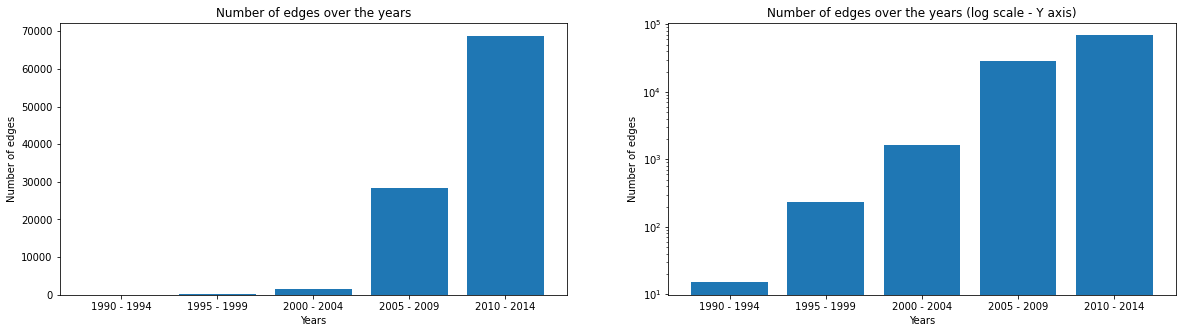

In [7]:

edge_number_histogram = {f'{year_range[0]} - {year_range[1]}':graph_list[i].number_of_edges() for i, year_range  in enumerate(years_range)}
fig, axs = plt.subplots(1,2,figsize=(20,5))
for i in range(2):
    axs[i].bar(edge_number_histogram.keys(), edge_number_histogram.values())
    axs[i].set_xlabel("Years")
    axs[i].set_ylabel("Number of edges")
    titel = f'Number of edges over the years'
    if i>0:
        axs[i].set_yscale('log')
        titel += ' (log scale - Y axis)'
    axs[i].set_title(titel)

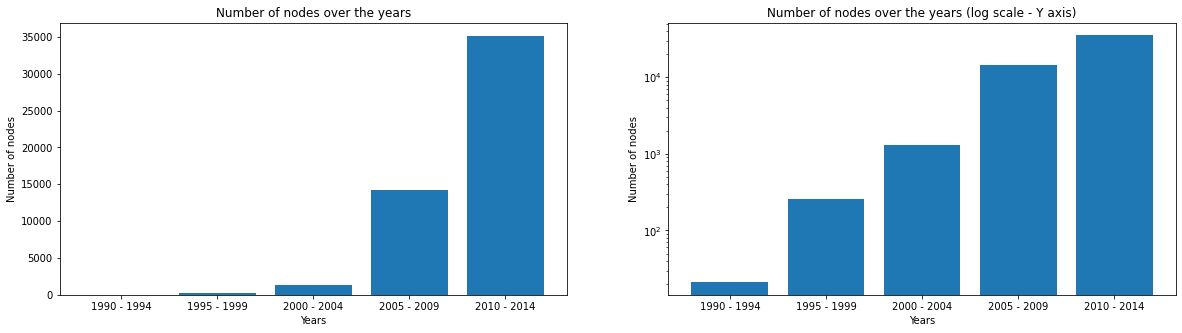

In [8]:
node_number_histogram = {f'{year_range[0]} - {year_range[1]}':graph_list[i].number_of_nodes() for i, year_range  in enumerate(years_range)}
fig, axs = plt.subplots(1,2,figsize=(20,5))
for i in range(2):
    axs[i].bar(node_number_histogram.keys(), node_number_histogram.values())
    axs[i].set_xlabel("Years")
    axs[i].set_ylabel("Number of nodes")
    titel = f'Number of nodes over the years'
    if i>0:
        axs[i].set_yscale('log')
        titel += ' (log scale - Y axis)'
    axs[i].set_title(titel)

#### Measures, Features and Plotting

MultiDiGraph with 256 nodes and 233 edges


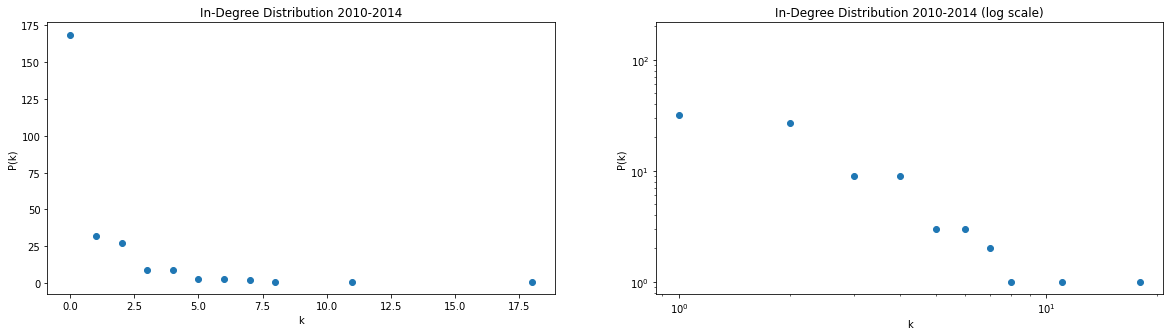

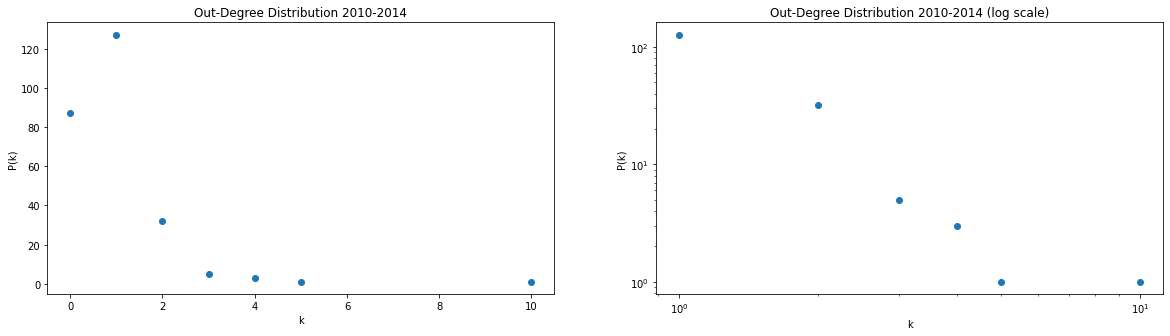

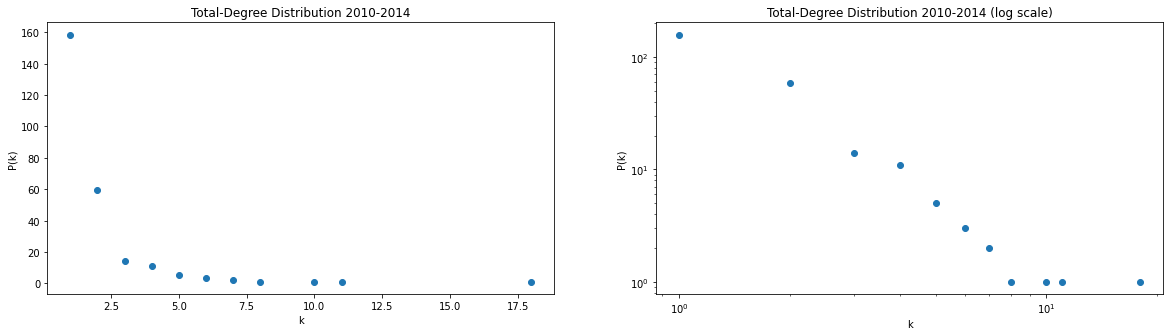

In [9]:
plot_degree_distribution(graph_list[1])

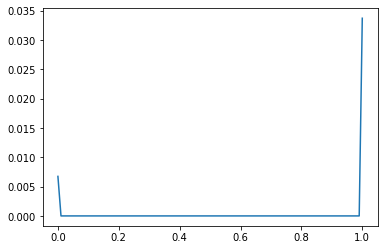

In [11]:
from scipy.stats import poisson
import matplotlib.pyplot as plt
%matplotlib inline 

#generate Poisson distribution with sample size 10000
x = poisson.rvs(mu=3, size=1000)
a = np.linspace(0, 1, 100)
b = poisson.pmf(a, mu=5)

#create plot of Poisson distribution
plt.plot(a,b)


Calculating best minimal value for power law fit
Gamma (Total) = 2.7094613035130446


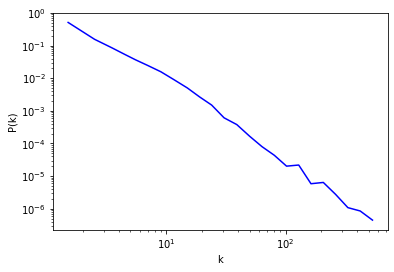

In [12]:
plot_gamma(graph_list[4])

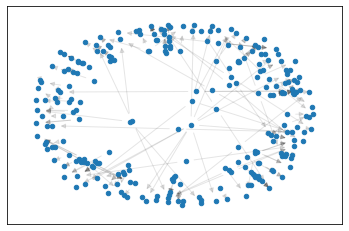

In [13]:
# Plot directional Graph

# G = nx.MultiDiGraph()
# edges = [df_list[3]]
# G = nx.from_pandas_edgelist(df=df_list[1],source='Investor_Name',target='Company_Name',edge_attr=True,create_using=nx.MultiDiGraph())
G = graph_list[1]
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 20)
nx.draw_networkx_edges(G,pos,alpha=0.1)
# nx.draw_networkx_labels(G, pos)
plt.show()

In [14]:
plot_giant_component(graph_list_bipartite[1], 1)

Graph of years 1995-1999 is unconnected
Size giant componenet = 34


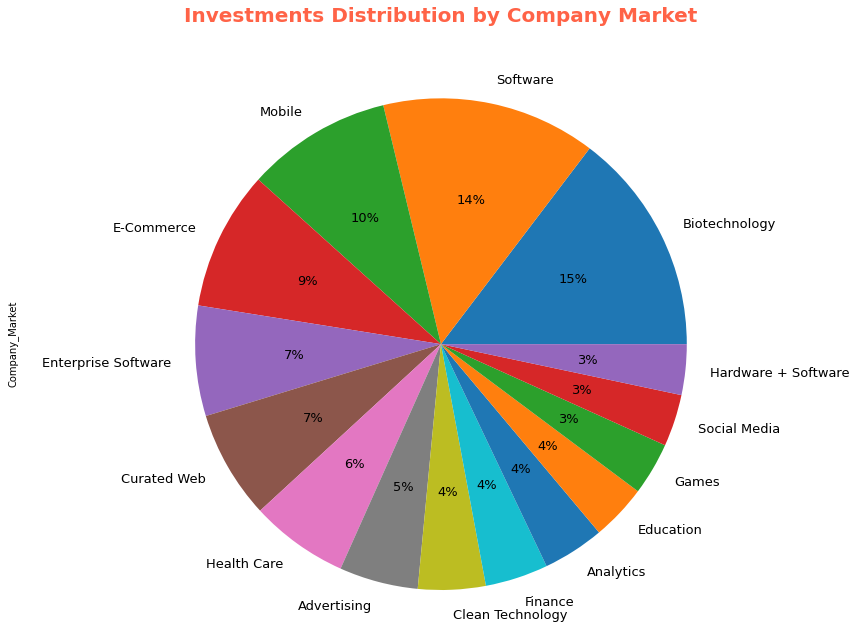

In [15]:
plot_company_market_distribution(df_list[4])

Graphs - number of edges
years_range = [(1990, 1994), (1995, 1999), (2000, 2004), (2005,2009), (2010, 2014)]

In [17]:
def build_centrality_table(num):    
    G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.MultiDiGraph())
    nodes = pd.DataFrame(list(G.nodes))
    #degree_centrality, in_degree_centrality, out_degree_centrality, betweenness_centrality and closeness_centrality
    measures = {'Degree': nx.degree_centrality,'In-Degree': nx.in_degree_centrality,'Out-Degree': nx.out_degree_centrality,'Betweenness': nx.betweenness_centrality,'Closeness': nx.closeness_centrality}

    for name, measure in measures.items():
        if name == 'Betweenness':
            G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.DiGraph())
            centrality_dict = measure(G,k=min(len(G.nodes),50000))
            pass
        else:
            centrality_dict = measure(G)
        nodes[name] = nodes[0].apply(lambda x: centrality_dict.get(x, None))
    return nodes

In [18]:
centrality_table = build_centrality_table(1).rename(columns={0: "Company Name"})
centrality_table

,Company Name,Degree,In-Degree,Out-Degree,Betweenness,Closeness
0,CMGI @Ventures,0.007843,0.000000,0.007843,0.000000,0.000000
1,GeoCities,0.023529,0.023529,0.000000,0.000000,0.019216
2,Sequoia Capital,0.011765,0.000000,0.011765,0.000000,0.000000
3,Yahoo!,0.019608,0.015686,0.003922,0.000046,0.011765
4,Kleiner Perkins Caufield & Byers,0.011765,0.000000,0.011765,0.000000,0.000000
...,...,...,...,...,...,...
251,Goldpocket Interactive,0.007843,0.007843,0.000000,0.000000,0.007843
252,Comdisco Ventures,0.003922,0.000000,0.003922,0.000000,0.000000
253,ServiceMaster Home Service Center,0.003922,0.003922,0.000000,0.000000,0.003922
254,New England Partners,0.003922,0.000000,0.003922,0.000000,0.000000


In [19]:
def print_centralization(num,measure):    
    table = centrality_table.sort_values([measure],ascending=False).head(10)[['Company Name',measure]]
    max_centrality = table.max()[1]
    G = nx.from_pandas_edgelist(df_list[num],source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.DiGraph())
    table['difference'] = max_centrality-table[measure]
    centralization = table['difference'].sum()/((G.number_of_nodes()-1)*(G.number_of_nodes()-2))
    print(f'The centralization is {centralization}')

In [20]:
centrality_table.sort_values(['Degree'],ascending=False).head(10)[['Company Name','Degree']]

,Company Name,Degree
120,Cooking.com,0.070588
104,Answers Corporation,0.043137
21,IDG Capital Partners,0.039216
55,Shopzilla,0.031373
98,Salesforce,0.027451
33,iPrint,0.027451
1,GeoCities,0.023529
190,ACTIVE Network,0.023529
168,OurHouse,0.023529
16,PowerDsine,0.019608


In [21]:
print_centralization(1,'Degree')

The centralization is 5.812422236147817e-06


In [22]:
centrality_table.sort_values(['In-Degree'],ascending=False).head(10)[['Company Name','In-Degree']]

,Company Name,In-Degree
120,Cooking.com,0.070588
104,Answers Corporation,0.043137
55,Shopzilla,0.031373
98,Salesforce,0.027451
33,iPrint,0.027451
190,ACTIVE Network,0.023529
1,GeoCities,0.023529
168,OurHouse,0.023529
154,Studio Systems,0.019608
246,Trivnet,0.019608


In [23]:
print_centralization(3,'In-Degree')

The centralization is 1.950935450716879e-09


In [24]:
centrality_table.sort_values(['Out-Degree'],ascending=False).head(10)[['Company Name','Out-Degree']]

,Company Name,Out-Degree
21,IDG Capital Partners,0.039216
172,Trident Capital,0.019608
13,Smedvig Capital,0.015686
114,Intel Capital,0.015686
169,Gabriel Venture Partners,0.015686
10,Flatiron Partners,0.011765
2,Sequoia Capital,0.011765
4,Kleiner Perkins Caufield & Byers,0.011765
86,SV Angel,0.011765
127,Tredegar Investments,0.011765


In [25]:
print_centralization(3,'Out-Degree')

The centralization is 1.120339169718604e-09


In [26]:
centrality_table.sort_values(['Betweenness'],ascending=False).head(10)[['Company Name','Betweenness']]

,Company Name,Betweenness
3,Yahoo!,0.000046
0,CMGI @Ventures,0.000000
176,Dynamics Direct,0.000000
163,Group Arnault,0.000000
164,Netflix,0.000000
165,Morningstar,0.000000
166,Nokia Ventures,0.000000
167,Ace Hardware,0.000000
168,OurHouse,0.000000
169,Gabriel Venture Partners,0.000000


In [27]:
print_centralization(3,'Betweenness')

The centralization is 2.053296061797604e-12


In [28]:
centrality_table.sort_values(['Closeness'],ascending=False).head(10)[['Company Name','Closeness']]

,Company Name,Closeness
104,Answers Corporation,0.043137
120,Cooking.com,0.039216
98,Salesforce,0.027451
33,iPrint,0.027451
168,OurHouse,0.023529
55,Shopzilla,0.019608
154,Studio Systems,0.019608
16,PowerDsine,0.019608
246,Trivnet,0.019608
1,GeoCities,0.019216


In [29]:
print_centralization(3,'Closeness')

The centralization is 8.518440928377661e-10


Average clustering coefficient for random graph is 0.00022496130845747254


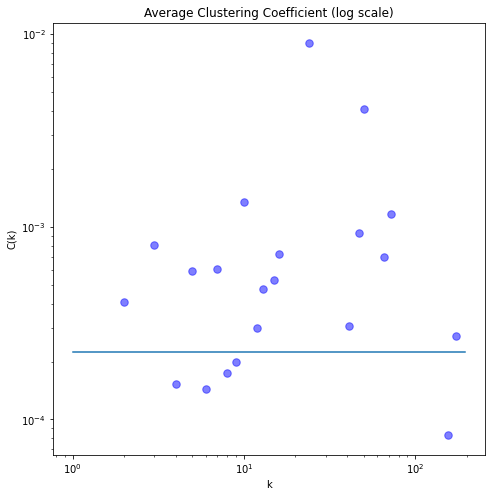

In [30]:
plot_clustering_coefficient(graph_list_bipartite[3], 3)

Assortative graph with mu 0.005


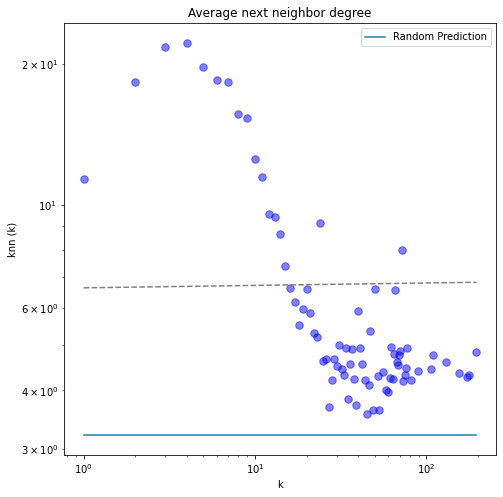

In [31]:
plot_knn(graph_list_bipartite[3])

c:\Files\TAU\Year 4\רשתות מורכבות\Complex_Networks\functions\plots.py:12: RuntimeWarning: invalid value encountered in power
  return (a*x)**mu
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


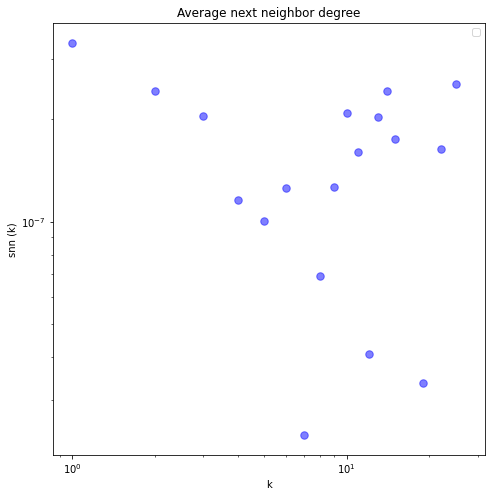

In [32]:
plot_snn(graph_list[2])

In [33]:
print_degree_correlation_coefficient(graph_list[2])

Neutral graph (r = 0)


c:\Program Files\Python39\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 The average weight is 10730511.609 USD


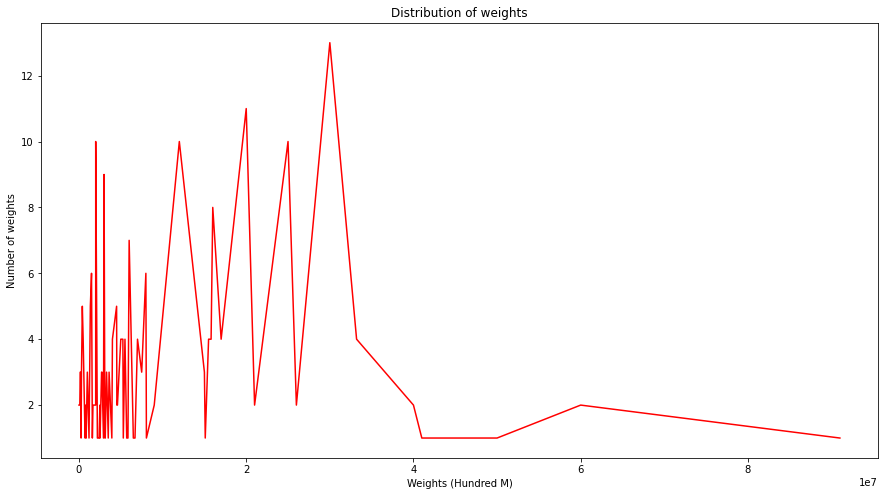

In [34]:
plot_weight_dist(graph_list[1])
    

Average distance is 1.014
Maximum distance is 2


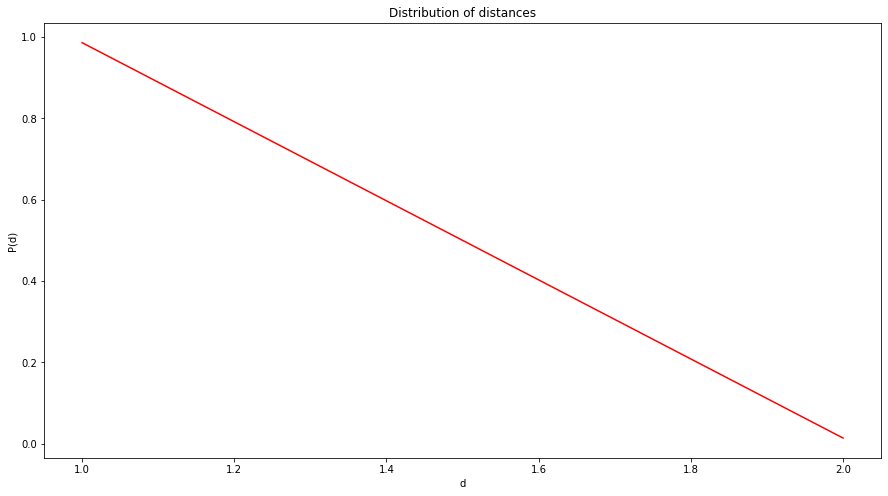

In [35]:
plot_distance_dist(graph_list[1])

Bipartite Graph - Connect investors and companies
Investor Projection: There is an edge between two investors if they invested in the same company
Company Projection: There is an edge between two companies if they have the same investor


In [36]:
#
# companies_edges = []
# investors_edges = []
# all_edges = []
# for df in df_list:
#     companies = defaultdict(set)
#     investors = defaultdict(set)
#     edges = []
#     for index, row in df.iterrows():
#         companies[row['Company_Name']].add(row['Investor_Name'])
#         investors[row['Investor_Name']].add(row['Company_Name'])
#         # add to edges a tuple of (company, investor, {weight: amout_usd})
#         edges.append((row['Company_Name'], row['Investor_Name'], {"Weight": row['Raised_Amount_USD']} ))
        
#     attr_dic = {x:y for x, y in zip(df['Company_Name'], df['Company_Market'])}
#     attr_dic_fixed = {x:'Investors' for x in df['Investor_Name']}
#     attr_dic_fixed.update(attr_dic)
#     nx.set_node_attributes(graph, attr_dic_fixed, name="Sector")
#     companies_edges.append(companies)
#     investors_edges.append(investors)
#     all_edges.append(edges)
# # for i,df in enumerate(df_list):
# #     
# print(all_edges[0])
# # print(companies_edges)
# # print(investors_edges)

## Communities

In [38]:
KL_communities_generator = community.kernighan_lin_bisection(graph_list_bipartite[3], max_iter=10)
print(len([com for com in KL_communities_generator]))
# GN_communities_generator = community.girvan_newman(graph_list_bipartite[3]) # not converging
greedy_modularity_sets = list(community.greedy_modularity_communities(graph_list_companies[3]))
community_investors = graph_list_companies[3].copy()
j = 0
for s in greedy_modularity_sets:
    j += 1
    for node in list(s):
        community_investors.nodes[node]['community'] = j
nx.write_gexf(community_investors,'gephi/CommunityCompanies3.gexf')
# x = next(GN_communities_generator)
# x2 = next(GN_communities_generator)
# print(x2)
#Communitys(graph_list_bipartite[3])

2


## Advanced analysis

- Can we predict from the network if a start up will succeed or fail?
- What is the startup sector that succeeds the most?
- What is the startup sector that fails the most?

##### Preprocess dataset

In [39]:
fail_sectors = defaultdict(int)
success_sectors = defaultdict(int)
startup_data = pd.read_csv("data/startup_data.csv", infer_datetime_format=True) # This has american startups
startup_data = startup_data[['name', 'founded_at', 'closed_at']]
startup_data['name'] = startup_data.name.apply(lambda x: str(x).lower())
startup_data['founded_at'] = startup_data.founded_at.apply(lambda x: str(x).split("/")[-1] if x is not None else None) # leave only year
startup_data['closed_at'] = startup_data.closed_at.apply(lambda x: str(x).split("/")[-1] if x is not None else None)
original_df['Company_Name'] = original_df['Company_Name'].apply(lambda x: str(x).lower())
company_names = list(map(lambda x: str(x).lower(), original_df["Company_Name"].unique()))
startup_names = set(list(map(lambda x: str(x).lower(), startup_data['name'].unique())))

years_range = [(1990, 1994), (1995, 1999), (2000, 2004), (2005,2009), (2010, 2014)]
#startup_df_list = [startup_data[(startup_data['founded_at'] <= year_range[1]) & (startup_data['founded_at'] >= year_range[0])] for year_range in years_range]
count = 0
fail_count = 0
for company in company_names:
    if company in startup_names:
        row = startup_data.loc[startup_data['name'] == company]
        row_from_original_dataset = original_df.loc[original_df["Company_Name"] == company].iloc[0] # get first match of the company
        company_sector = row_from_original_dataset.values[1] # values - 0 is name, 1 is market, 2 is investor, 3 fund year 4 usd)
        
        if row.values[0][2] != "nan":
            fail_count +=1
            fail_sectors[company_sector] += 1
        else:
            success_sectors[company_sector] += 1
        count +=1
print(fail_count)
print(count)
success_histogram = {key:value for key,value in [(k,v) for k, v in sorted(success_sectors.items(), key=lambda item: item[1], reverse=True)][:10]}
fail_histogram = {key:value for key,value in [(k,v) for k, v in sorted(fail_sectors.items(), key=lambda item: item[1], reverse=True)][:10]}


319
899


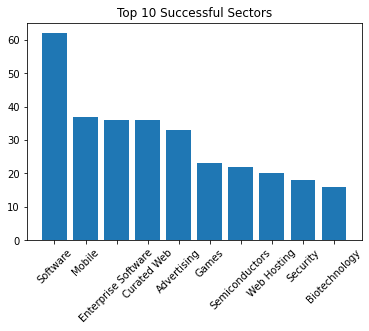

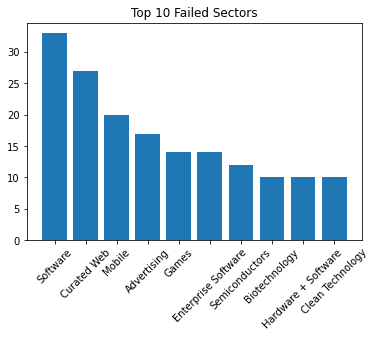

In [40]:
plot_histogram(success_histogram,'Top 10 Successful Sectors')
plot_histogram(fail_histogram, 'Top 10 Failed Sectors')

In [41]:
##############################################################
####################### Do Not Delete ########################
##############################################################

# # Make the gephi's files
# graph_list_for_attr = []
# for i,df in enumerate(df_list):
#     attr_dic = {x:y for x, y in zip(df['Company_Name'], df['Company_Market'])}
#     attr_dic_fixed = {x:'Investors' for x in df['Investor_Name']}
#     attr_dic_fixed.update(attr_dic)
#     graph = nx.from_pandas_edgelist(df,source='Investor_Name',target='Company_Name', edge_attr=['Company_Market','Raised_Amount_USD'], create_using=nx.MultiDiGraph())
#     nx.set_node_attributes(graph, attr_dic_fixed, name="Sector")
#     graph_list_for_attr.append(graph)
#     nx.write_gexf(graph, f"Gephi{i}.gexf")